1.3578437019523239e+70 GeV2 / cm3
1.031414488806459e+16 GeV2 / cm5


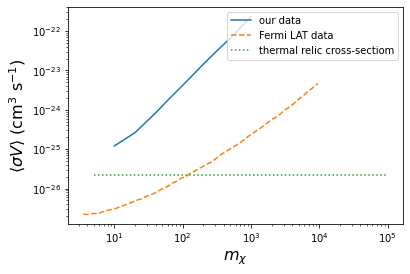

In [1]:
import numpy as np
from scipy.integrate import simpson
from astropy import units as u
from astropy import constants as c
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import interp1d
from scipy import stats


# Nevaro Frenk White Profile
rs = (0.287*u.Mpc).value
Rmax = (0.89*u.Mpc).value
z = np.logspace(-3,2,101)
r = np.logspace(-3,np.log10(Rmax),101)
z_grid,r_grid = np.meshgrid(z,r,indexing="ij")
ρs = ((1.86*10**6)*(u.M_sun/((u.kpc).to(u.Mpc))**3)).value 

def ρ(r,rs,ρs):
    x = r/rs
    return ρs/ x/(1+x)**2 


def f(r,z):
    x = np.sqrt(r**2+z**2)
    return 4*np.pi*(ρ(x,rs,ρs)**2)*r

# Integral for the J-facto
I_1 = simpson(f(r_grid,z_grid),z_grid,axis=0)
I_2 = simpson(I_1,r,axis=-1)

unit_factor = (("u.M_sun**2/u.Mpc**3")*c.c**4).to(u.GeV**2/u.cm**3)
I = (unit_factor)*I_2
print(I)




#Finding the J-factor
d_L = (104.89452*u.Mpc).to(u.cm) #d_L is the luminosty distance at z =0.0231
J_factor = (I/(4*np.pi*(d_L)**2))
     
print(J_factor)


# Chi Squared model



from sympy import Chi
data_two = np.loadtxt("true..csv", unpack=True)

def χ_squared(model,data,axis=-1,dataUncert=None,alpha=2):
    if dataUncert is None:
        dataUncert = data 
    if dataUncert.shape != data.shape or model.shape != data.shape:
        #print("χ_squared error: model, data, and dataUncert (if specified) must be the same shape!")
        sys.exit(2)
    return np.sum((model-data)**alpha/dataUncert**alpha,axis=axis) 

data = np.loadtxt("AtProduction_gammas (1).dat", unpack=True)
coma_data = np.loadtxt("coma_fermi_2016.txt",unpack=True)
M = np.unique(data[0])
upperLims= []
mass_set = [10,20,40,60,1e2,2e2,3e2,5e2,1e3]
for m in mass_set:
        x = 10**data[1][data[0]==m]
        y = data[13][data[0]==m]
        dN_dE = y/m/x/np.log(10)
        coma_x = coma_data[0]*1e-3
        coma_y = coma_data[1]*1e-3
        sigv = np.logspace(1,6,num=300)*1e-26 
        f = interp1d(x*m,dN_dE,fill_value=0.0,bounds_error=False)
        Boost_factor =  17.77096750030117 # Boost factor Computed seperately
        ϕ = J_factor*f(coma_x)/2/(m**2)*coma_x*Boost_factor # flux of i particles
        model = np.tensordot(ϕ.value,sigv,axes=0)
        fit_data = np.tensordot(coma_y,np.ones_like(sigv),axes=0)
        #print(ϕ)
        #print(model)
        chi2 = χ_squared(model,fit_data,axis = 0)
        chiDiff = chi2 - np.min(chi2)
        cdf = stats.chi2.cdf(chiDiff,len(ϕ)-1)
        upperLims.append(np.min(sigv[cdf>=0.95]))



plt.plot(mass_set,upperLims,linestyle="-",label= "our data")
plt.plot(data_two[0],data_two[1],linestyle ="--",label="Fermi LAT data")
plt.plot(M,np.ones_like(M)*2.2e-26,linestyle=":",label="thermal relic cross-sectiom") 
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\langle \sigma V\rangle$ (cm$^3$ s$^{-1}$)",fontsize=16) # c
plt.xlabel(r"$m_\chi$",fontsize=16) # Dark matter mass 
plt.savefig('rlvsFermi')
plt.legend()
plt.show()
